In [15]:
from detect_code.detect3 import load_model, predict
# mobilenet_v3_ssd320_voc0712.yaml
# model_004500.pth
config_file1="/home/atharvaj/Desktop/SSD/configs/efficient_net_b3_ssd300_voc0712.yaml"
checkpoint_file1="/home/atharvaj/Desktop/SSD/models_pth/ssdEff-v1.pth"
model1 = load_model(config_file=config_file1, checkpoint_file=checkpoint_file1)

config_file2="/home/atharvaj/Desktop/SSD/configs/mobilenet_v3_ssd320_voc0712.yaml"
checkpoint_file2="/home/atharvaj/Desktop/SSD/models_pth/ssdMob-v1.pth"
model2 = load_model(config_file=config_file2, checkpoint_file=checkpoint_file2)

config_file3="/home/atharvaj/Desktop/SSD/configs/vgg_ssd300_voc0712.yaml"
checkpoint_file3="/home/atharvaj/Desktop/SSD/models_pth/vgg_model_3000.pth"
# checkpoint_file3="/home/atharvaj/Desktop/SSD/models_pth/model_001500.pth"
model3 = load_model(config_file=config_file3, checkpoint_file=checkpoint_file3)

config_file4="/home/atharvaj/Desktop/SSD/configs/resnet_50_ssd300_voc0712.yaml"
checkpoint_file4="/home/atharvaj/Desktop/SSD/models_pth/resnet50-v1.pth"
# checkpoint_file3="/home/atharvaj/Desktop/SSD/models_pth/model_001500.pth"
model4 = load_model(config_file=config_file4, checkpoint_file=checkpoint_file4)


Loaded pretrained weights for efficientnet-b3


/home/atharvaj/Desktop/SSD/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/atharvaj/Desktop/SSD/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:

from ensemble_boxes import weighted_boxes_fusion

weights = [0.4915, 0.6202, 0.6111, 0.6858]
iou_thr = 0.5
skip_box_thr = 0.0001

In [42]:
# models = [model1, model2, model3]
models = [model1, model2, model3, model4]
config_files = [config_file1, config_file2, config_file3, config_file4]
# models=[model2]
# config_files=[config_file2]
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/71025739-black-man-holding-a-pistol.jpg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/resized_image_white.jpg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/images.jpeg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/678499c5-2914-44d0-a576-d038b357ed0f.jpeg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/eb511fe6-9482-4bbd-a66a-abad3748f5f7.jpeg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/knife.jpg"
# img_path = "ip_images/image.png"
img_path = "/home/atharvaj/Desktop/SSD/ip_images/image copy.png"
output_dir = "/home/atharvaj/Desktop/SSD/op_images"
def predict_imgs(models, config_files, img_path, output_dir):
    final_bb = []
    final_conf = []
    final_scores = []
    for i, model in enumerate(models):
        if model is None:
            continue
        else:
            print(f"Predicting with model {i+1}")   
            res = predict(model, config_files[i], img_path, output_dir)
            final_bb.append(res[0])
            final_scores.append(res[1].cpu().numpy().tolist())
            final_conf.append(res[2].cpu().numpy().tolist())
    return final_bb, final_scores, final_conf  

boxes_list, labels_list, scores_list = predict_imgs(models, config_files, [img_path], output_dir)
print('\n\n')
print(boxes_list)
print(scores_list)
print(labels_list)

Predicting with model 1
Box: [0.3753095245361328, 0.45228185017903644, 0.8157632954915365, 0.9895892333984375], Label: knife, Score: 0.68
Box: [0.11470890045166016, 0.055611521402994794, 0.71646728515625, 0.6502480570475261], Label: gun, Score: 0.61
180 279
104.71135734558105 81.41073303222656 227.5979594421387 178.12606201171874
104 81 227 178
180 279
32.003783226013184 10.010073852539064 199.89437255859374 117.04465026855469
32 10 199 117
Saved result to /home/atharvaj/Desktop/SSD/op_images/image copy.png
Predicting with model 2
Box: [0.4074689865112305, 0.443523645401001, 0.8499686241149902, 0.9613818168640137], Label: knife, Score: 0.67
Box: [0.10790524482727051, 0.033327966928482056, 0.679376220703125, 0.6025495529174805], Label: gun, Score: 0.59
180 279
113.6838472366333 79.83425617218018 237.14124612808226 173.04872703552246
113 79 237 173
180 279
30.105563306808474 5.99903404712677 189.54596557617188 108.45891952514648
30 5 189 108
Saved result to /home/atharvaj/Desktop/SSD/op_

In [43]:


boxes, scores, labels = weighted_boxes_fusion(conf_type='box_and_model_avg', boxes_list=boxes_list, scores_list=scores_list, labels_list=labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
print(boxes, scores, labels)

[[0.38847905 0.4491376  0.84459168 0.96441722]
 [0.12282743 0.03806053 0.681117   0.63335222]] [0.76379165 0.71453618] [2. 1.]


In [44]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ssd.default import class_names_defined


def show_img(img_path, boxes, scores, labels):
# Load the image using cv2
    img = cv2.imread(img_path)  # img_path should be the path to the image

    # Convert from BGR (OpenCV default) to RGB (Matplotlib default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create a plot
    plt.figure(figsize=(12, 8))
    plt.imshow(img)  # Use the loaded image array here
    ax = plt.gca()

    # Get the image dimensions
    img_height, img_width = img.shape[:2]

    # Loop through the boxes, scores, and labels to draw rectangles and labels
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        x1 *= img_width
        y1 *= img_height
        x2 *= img_width
        y2 *= img_height

        width = x2 - x1
        height = y2 - y1

        # Create rectangle
        rect = plt.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        print(score, label)
        # Add label
        label_text = f"{class_names_defined[int(label)]}: {score:.2f}"
        plt.text(x1, y1-2, label_text,
                color='blue',
                fontsize=10,
                va='top',
                backgroundcolor=(0, 0, 0, 0.5))

    plt.axis('off')
    plt.show()


0.7637916471539785 2.0
0.7145361780828142 1.0


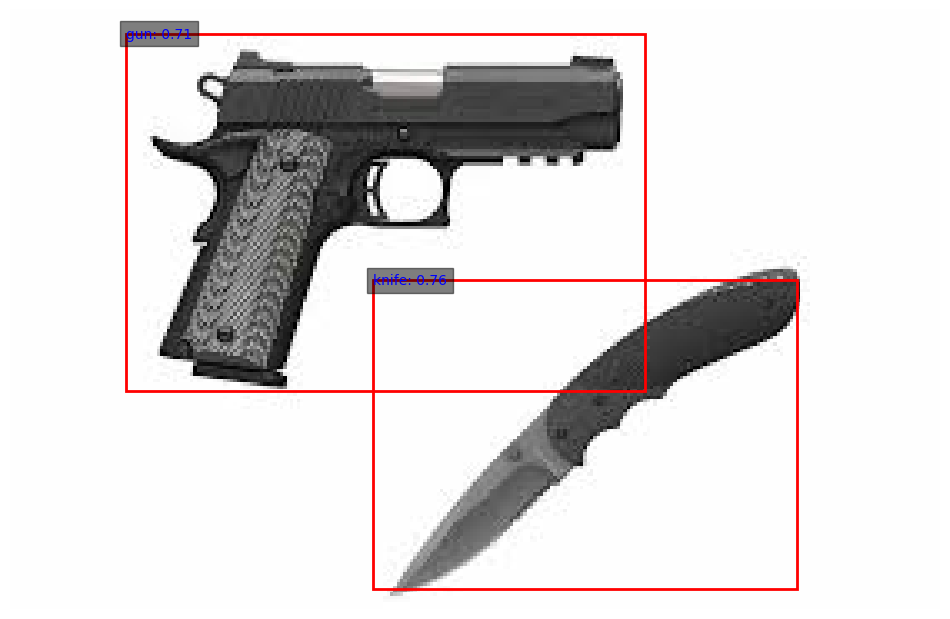

In [45]:
show_img(img_path, boxes, scores, labels)